# Below are three parts:
# Part1: 
# Mortality Rate and Incident Rate Differences between Different Countries;
# Part2: 
# HealthPolicy and ClosurePolicy Index Differences between Different Countries
# Part3: 
# Sub-HealthPolicy Index Differences between Different Countries

# Part1: 
# Mortality Rate and Incident Rate Differences between Different Countries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests
import calmap

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load data

In [2]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

## Preprocess Data

In [3]:
df_covid19 = df_covid19.drop(["People_Tested","People_Hospitalized","UID","ISO3","Mortality_Rate"],axis =1)
df_covid19.head(2)

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate
0,Afghanistan,2020-12-05 23:26:05,33.93911,67.709953,47072.0,1864.0,37393.0,7815.0,120.919615
1,Albania,2020-12-05 23:26:05,41.15330,20.168300,42148.0,889.0,21286.0,19973.0,1464.591007


In [5]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]
# df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

In [7]:
df_table = df_table[df_table["continent"] != "Others"]

In [8]:
df_deaths[df_deaths["continent" ]== 'Others']

,state,country,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20
34,NaN,Burma,Others,21.916200,95.956000,0,0,0,0,0,...,1810,1846,1865,1887,1918,1941,1972,1998,2028,2059
104,NaN,Diamond Princess,Others,0.000000,0.000000,0,0,0,0,0,...,13,13,13,13,13,13,13,13,13,13
141,NaN,Holy See,Others,41.902900,12.453400,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
158,NaN,Kosovo,Others,42.602636,20.902977,0,0,0,0,0,...,948,963,975,989,1005,1016,1026,1026,1026,1026
170,NaN,MS Zaandam,Others,0.000000,0.000000,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
241,NaN,Timor-Leste,Others,-8.874217,125.727539,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,NaN,West Bank and Gaza,Others,31.952200,35.233200,0,0,0,0,0,...,665,680,689,704,717,732,747,763,780,797
267,NaN,Western Sahara,Others,24.215500,-12.885800,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [9]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)
# df_recovered = df_recovered.replace(np.nan, '', regex=True)
# df_active = df_active.replace(np.nan, '', regex=True)

In [11]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

df_countries_cases.fillna(0,inplace=True)
df_continents_cases.fillna(0,inplace=True)

In [12]:
df_t = pd.DataFrame(pd.to_numeric(df_countries_cases.sum()),dtype=np.float64).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["Deaths"]/df_t["Confirmed"],2)
df_t.style.background_gradient(cmap='Wistia',axis=1).format("{:.2f}").format("{:.0f}",subset=["Confirmed","Deaths","Recovered","Active"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
0,66442818,1527209,42576816,21284699,239227.97,2.30


In [13]:
df_continents_cases["Mortality Rate (per 100)"] = np.round(100*df_continents_cases["Deaths"]/df_continents_cases["Confirmed"],2)
df_continents_cases.style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Pastel1_r',subset=["Incident_Rate"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\
                        .format("{:.2f}")\
                        .format("{:.0f}",subset=["Confirmed","Deaths","Recovered","Active"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
continent,,,,,,
Africa,2249651,53554,1917908,278189,12960.13,2.38
Asia,17199466,297123,15201936,1700407,50929.26,1.73
Australia,30771,942,28270,1559,175.10,3.06
Europe,18322208,420704,7726164,9121246,124202.28,2.30
North America,16923883,419393,7256419,9248071,22589.21,2.48
Others,237271,3996,176198,57077,7744.02,1.68
South America,11479568,331497,10269921,878150,20627.97,2.89


## Sort countries by Incident Rate

In [15]:
df_countries_cases["Mortality Rate (per 100)"] = np.round(100*df_countries_cases["Deaths"]/df_countries_cases["Confirmed"],2)
df_countries_cases.sort_values('Incident_Rate', ascending= False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Pastel1_r',subset=["Incident_Rate"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\
                        .format("{:.2f}")\
                        .format("{:.0f}",subset=["Confirmed","Deaths","Recovered","Active"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
country,,,,,,
Andorra,7005,78,6171,756,9066.20,1.11
Montenegro,37879,530,26809,10540,6031.09,1.40
Luxembourg,37017,345,28029,8643,5913.49,0.93
San Marino,1789,48,1412,329,5271.38,2.68
Bahrain,87732,341,85876,1515,5155.90,0.39
Czechia,544112,8782,474167,61163,5080.89,1.61
Belgium,587439,17142,0,0,5068.67,2.92
Qatar,139783,239,137060,2484,4851.79,0.17
Armenia,140959,2309,116066,22584,4756.93,1.64


## We focus on reletive values rather than absolute values.

## For Incident Rate (per 100,000):
### Top 25 countries:(those have highest incident rate)
Andorra  AD,Montenegro  ME(CS),Luxembourg  LU,San Marino  SM,Bahrain  BH,Czechia  CZ,Belgium  BE,Qatar  QA,Armenia  AM,USA  US,Slovenia  SI,Panama  PA,Switzerland  CH,Israel  IL,Georgia  GE,Liechtenstein  LI, Spain  ES,Croatia  HR,France  FR,Kuwait  KW,Austria  AT,Netherlands  NL,North Macedonia  MK,Argentina  AR,Portugal  PT,Brazil  BR,Peru  PE,Chile  CL,Moldova  MD.
### Bottom 25 countries:(those have lowest incident rate)
Vietnam  VN,Thailand  TH,Burundi  BI,China  CN,Niger  NE,Papua New Guinea  PG,Yemen  YE,Chad  TD,Democratic Republic of the Congo  CD,Burkina Faso  BF,Eritrea  ER,Mali  ML,Benin  BJ,Mongolia  MN,South Sudan  SS,Somalia  SO,Sierra Leone  SL,Malawi  MW,Liberia  LR,Nigeria  NG,Togo  TG,Mauritius  MU,New Zealand  NZ,Sudan  SD,Rwanda  RW.

## Sort countries by Mortality Rate

In [16]:
df_countries_cases.sort_values('Mortality Rate (per 100)', ascending= False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Pastel1_r',subset=["Incident_Rate"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\
                        .format("{:.2f}")\
                        .format("{:.0f}",subset=["Confirmed","Deaths","Recovered","Active"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
country,,,,,,
Yemen,2304,633,1547,124,7.72,27.47
MS Zaandam,9,2,7,0,0.00,22.22
Western Sahara,10,1,8,1,1.67,10.00
Mexico,1156770,108863,852719,195188,905.20,9.41
Ecuador,197391,13756,169804,13831,1118.80,6.97
Sudan,19196,1290,10942,6964,43.78,6.72
Bolivia,145325,8987,124390,11948,1244.96,6.18
Chad,1722,102,1561,59,10.48,5.92
Egypt,118014,6750,103324,7940,115.32,5.72


## For Mortality Rate (per 100):
### Top 25 countries:(those have highest mortality rate)
Yemen,Mexico,Ecuador,Sudan,Bolivia,Chad,Egypt,Syria,China,Liberia,Iran,Niger,Tanzania,Afghanistan,Peru,United Kingdom,Italy,Tunisia,Guatemala,Gambia,Australia,Mali,Bosnia and Herzegovina,Indonesia,Sierra Leone				
### Bottom 25 countries:(choose whose total cases are more than 500)
Eritrea,Mongolia,Singapore,Burundi,Qatar,Botswana,United Arab Emirates,Maldives,Bahrain,Cyprus,Monaco,Iceland,Sri Lanka,Malaysia,Guinea,Côte d'Ivoire,Kuwait,Ghana,Gabon,Nepal,Tajikistan,Lebanon,Mozambique,Belarus,Uzbekistan	

## I think "incident rate" is more relevant to how well each country try to stop the spread of COVID-19, and mortality rate is more relevant to the medical resource and healthcare system of one country. So I decide just to focus on "incident rate" to evaluate the performance.

# Part2: 
# HealthPolicy and ClosurePolicy Index Differences between Different Countries

## Load data

In [3]:
# Load CSV data directly from the URL with pandas, the options are needed to prevent
# reading of records with key "NA" (Namibia) as NaN
data = pd.read_csv(
    "https://storage.googleapis.com/covid19-open-data/v2/oxford-government-response.csv",
    keep_default_na=False,
    na_values=[""],
)

# NOTE: We are only downloading the last day of data, but you can download all
# the data at once if you'd like by changing the URL to:
# https://storage.googleapis.com/covid19-open-data/v2/main.csv

# Print a small snippet of the dataset
print(f"The dataset currently contains {len(data)} records, here is a sample:")
data.sample(2)

The dataset currently contains 87129 records, here is a sample:


,date,key,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,income_support,debt_relief,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,stringency_index
16493,2020-03-03,US_WI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,13.89
8036,2020-01-31,SK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,2.78


## Choose specific policies dataset (closure and health)

In [4]:
data_closure = data[['date','key','school_closing', 'workplace_closing', 'cancel_public_events','restrictions_on_gatherings','public_transport_closing','stay_at_home_requirements','restrictions_on_internal_movement','international_travel_controls']]
data_health = data[['date','key', 'testing_policy', 'contact_tracing','emergency_investment_in_healthcare','investment_in_vaccines']] 

## Preprocess data like normalizing and averaging data 

In [9]:
data_closure_NZ = data_closure[data_closure['key'] == "NZ"]

s1 = (data_closure_NZ['school_closing'] - data_closure_NZ['school_closing'].min())/(data_closure_NZ['school_closing'].max() - data_closure_NZ['school_closing'].min())
data_closure_NZ = data_closure_NZ.drop(['school_closing'],axis=1)
data_closure_NZ.insert(2,'school_closing',s1)
s2 = (data_closure_NZ['workplace_closing'] - data_closure_NZ['workplace_closing'].min())/(data_closure_NZ['workplace_closing'].max() - data_closure_NZ['workplace_closing'].min())
data_closure_NZ = data_closure_NZ.drop(['workplace_closing'],axis=1)
data_closure_NZ.insert(3,'workplace_closing',s2)
s3 = (data_closure_NZ['cancel_public_events'] - data_closure_NZ['cancel_public_events'].min())/(data_closure_NZ['cancel_public_events'].max() - data_closure_NZ['cancel_public_events'].min())
data_closure_NZ = data_closure_NZ.drop(['cancel_public_events'],axis=1)
data_closure_NZ.insert(4,'cancel_public_events',s3)
s4 = (data_closure_NZ['restrictions_on_gatherings'] - data_closure_NZ['restrictions_on_gatherings'].min())/(data_closure_NZ['restrictions_on_gatherings'].max() - data_closure_NZ['restrictions_on_gatherings'].min())
data_closure_NZ = data_closure_NZ.drop(['restrictions_on_gatherings'],axis=1)
data_closure_NZ.insert(5,'restrictions_on_gatherings',s4)
s5 = (data_closure_NZ['public_transport_closing'] - data_closure_NZ['public_transport_closing'].min())/(data_closure_NZ['public_transport_closing'].max() - data_closure_NZ['public_transport_closing'].min())
data_closure_NZ = data_closure_NZ.drop(['public_transport_closing'],axis=1)
data_closure_NZ.insert(6,'public_transport_closing',s5)
s6 = (data_closure_NZ['stay_at_home_requirements'] - data_closure_NZ['stay_at_home_requirements'].min())/(data_closure_NZ['stay_at_home_requirements'].max() - data_closure_NZ['stay_at_home_requirements'].min())
data_closure_NZ = data_closure_NZ.drop(['stay_at_home_requirements'],axis=1)
data_closure_NZ.insert(7,'stay_at_home_requirements',s6)
s7 = (data_closure_NZ['restrictions_on_internal_movement'] - data_closure_NZ['restrictions_on_internal_movement'].min())/(data_closure_NZ['restrictions_on_internal_movement'].max() - data_closure_NZ['restrictions_on_internal_movement'].min())
data_closure_NZ = data_closure_NZ.drop(['restrictions_on_internal_movement'],axis=1)
data_closure_NZ.insert(8,'restrictions_on_internal_movement',s7)
s8 = (data_closure_NZ['international_travel_controls'] - data_closure_NZ['international_travel_controls'].min())/(data_closure_NZ['international_travel_controls'].max() - data_closure_NZ['international_travel_controls'].min())
data_closure_NZ = data_closure_NZ.drop(['international_travel_controls'],axis=1)
data_closure_NZ.insert(9,'international_travel_controls',s8)

NZ_closure_average_ontime = data_closure_NZ.mean(axis = 0) 
NZ_closure_average = NZ_closure_average_ontime.mean()
print(NZ_closure_average)


data_health_NZ = data_health[data_health['key'] == "NZ"]
s1 = (data_health_NZ['testing_policy'] - data_health_NZ['testing_policy'].min())/(data_health_NZ['testing_policy'].max() - data_health_NZ['testing_policy'].min())
data_health_NZ = data_health_NZ.drop(['testing_policy'],axis=1)
data_health_NZ.insert(2,'testing_policy',s1)
s2 = (data_health_NZ['contact_tracing'] - data_health_NZ['contact_tracing'].min())/(data_health_NZ['contact_tracing'].max() - data_health_NZ['contact_tracing'].min())
data_health_NZ = data_health_NZ.drop(['contact_tracing'],axis=1)
data_health_NZ.insert(3,'contact_tracing',s2)
s3 = (data_health_NZ['emergency_investment_in_healthcare'] - data_health_NZ['emergency_investment_in_healthcare'].min())/(data_health_NZ['emergency_investment_in_healthcare'].max() - data_health_NZ['emergency_investment_in_healthcare'].min())
data_health_NZ = data_health_NZ.drop(['emergency_investment_in_healthcare'],axis=1)
data_health_NZ.insert(4,'emergency_investment_in_healthcare',s3)
s4 = (data_health_NZ['investment_in_vaccines'] - data_health_NZ['investment_in_vaccines'].min())/(data_health_NZ['investment_in_vaccines'].max() - data_health_NZ['investment_in_vaccines'].min())
data_health_NZ = data_health_NZ.drop(['investment_in_vaccines'],axis=1)
data_health_NZ.insert(5,'investment_in_vaccines',s4)

NZ_health_average_ontime = data_health_NZ.mean(axis = 0) 
NZ_health_average = NZ_health_average_ontime.mean()
print(NZ_health_average)

0.3179908839038342
0.402614174635803


## Compare the policy index differences between different countries(countries classification is from this website: https://www.endcoronavirus.org/countries)

## Green means best performance, yellow means moderate performance and red means worst performance.

In [30]:
x = ["AU","NZ","SG","TH","SO","CN","EG","IL","KG","TJ","US","BR","CA","PH","RU"]
y1 = [AU_closure_average,NZ_closure_average,SG_closure_average,TH_closure_average,SO_closure_average,
      CN_closure_average,EG_closure_average,IL_closure_average,KG_closure_average,TJ_closure_average,
      US_closure_average,BR_closure_average,CA_closure_average,PH_closure_average,RU_closure_average]
y2 = [AU_health_average,NZ_health_average,SG_health_average,TH_health_average,SO_health_average,
      CN_health_average,EG_health_average,IL_health_average,KG_health_average,TJ_health_average,
      US_health_average,BR_health_average,CA_health_average,PH_health_average,RU_health_average]

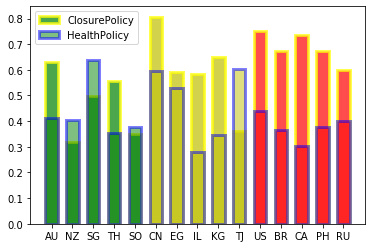

In [31]:
plt.bar(x, y1, alpha=0.7, width=0.6, color='gggggyyyyyrrrrr', edgecolor='yellow', label='ClosurePolicy', lw=3)
plt.bar(x, y2, alpha=0.5, width=0.6, color='gggggyyyyyrrrrr', edgecolor='blue', label='HealthPolicy', lw=3)
plt.legend(loc='upper left')
plt.show()

In [34]:
x1 = ["SG","CN","CA"]
y11 = [SG_closure_average,CN_closure_average,CA_closure_average]
y22 = [SG_health_average,CN_health_average,CA_health_average]

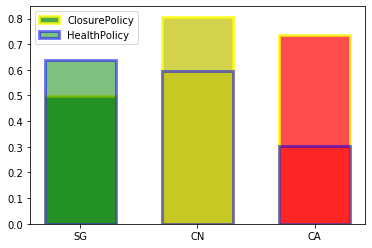

In [35]:
plt.bar(x1, y11, alpha=0.7, width=0.6, color='gyr', edgecolor='yellow', label='ClosurePolicy', lw=3)
plt.bar(x1, y22, alpha=0.5, width=0.6, color='gyr', edgecolor='blue', label='HealthPolicy', lw=3)
plt.legend(loc='upper left')
plt.show()

## Also, we compare the results between different countries by their Incident Rate (incident rates are calculated in another code file)
### Top 25 countries:(those have highest incident rate)(red)
Andorra  AD,Montenegro  ME(CS)(missing),Luxembourg  LU,San Marino  SM,Bahrain  BH,Czechia  CZ,Belgium  BE,Qatar  QA,Armenia  AM(missing),USA  US,Slovenia  SI,Panama  PA,Switzerland  CH,Israel  IL,Georgia  GE,Liechtenstein  LI(missing), Spain  ES,Croatia  HR,France  FR,Kuwait  KW,Austria  AT,Netherlands  NL,North Macedonia  MK(missing),Argentina  AR,Portugal  PT,Brazil  BR,Peru  PE,Chile  CL,Moldova  MD.
### Bottom 25 countries:(those have lowest incident rate)(green)
Vietnam  VN,Thailand  TH,Burundi  BI,China  CN,Niger  NE,Papua New Guinea  PG,Yemen  YE,Chad  TD,Democratic Republic of the Congo  CD,Burkina Faso  BF,Eritrea  ER,Mali  ML,Benin  BJ,Mongolia  MN,South Sudan  SS,Somalia  SO,Sierra Leone  SL,Malawi  MW,Liberia  LR,Nigeria  NG,Togo  TG,Mauritius  MU,New Zealand  NZ,Sudan  SD,Rwanda  RW.

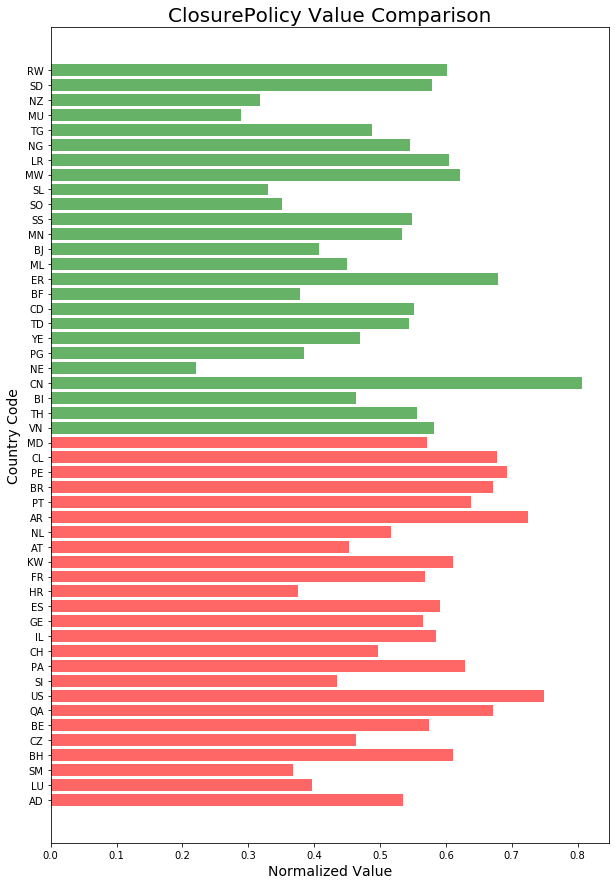

In [45]:
x = ["AD","LU","SM","BH","CZ","BE","QA","US","SI","PA","CH","IL","GE","ES","HR","FR", "KW","AT","NL","AR","PT","BR","PE","CL","MD","VN","TH","BI","CN","NE","PG","YE","TD","CD","BF","ER","ML","BJ","MN","SS","SO","SL","MW","LR","NG","TG","MU", "NZ","SD","RW"]
y1 = [AD_closure_average,LU_closure_average,SM_closure_average,BH_closure_average,CZ_closure_average,BE_closure_average, QA_closure_average,US_closure_average,SI_closure_average,PA_closure_average,CH_closure_average,IL_closure_average, GE_closure_average,ES_closure_average,HR_closure_average,FR_closure_average,KW_closure_average,AT_closure_average, NL_closure_average,AR_closure_average,PT_closure_average,BR_closure_average,PE_closure_average,CL_closure_average, MD_closure_average,VN_closure_average,TH_closure_average,BI_closure_average,CN_closure_average,NE_closure_average, PG_closure_average,YE_closure_average,TD_closure_average,CD_closure_average,BF_closure_average,ER_closure_average, ML_closure_average,BJ_closure_average,MN_closure_average,SS_closure_average,SO_closure_average,SL_closure_average, MW_closure_average,LR_closure_average,NG_closure_average,TG_closure_average,MU_closure_average,NZ_closure_average,SD_closure_average,RW_closure_average]

plt.figure(figsize=(10,15))

plt.title('ClosurePolicy Value Comparison',fontsize=20)
plt.xlabel(u'Normalized Value',fontsize=14)
plt.ylabel(u'Country Code',fontsize=14)
plt.barh(x, y1, alpha=0.6, color='rrrrrrrrrrrrrrrrrrrrrrrrrggggggggggggggggggggggggg')
plt.show()

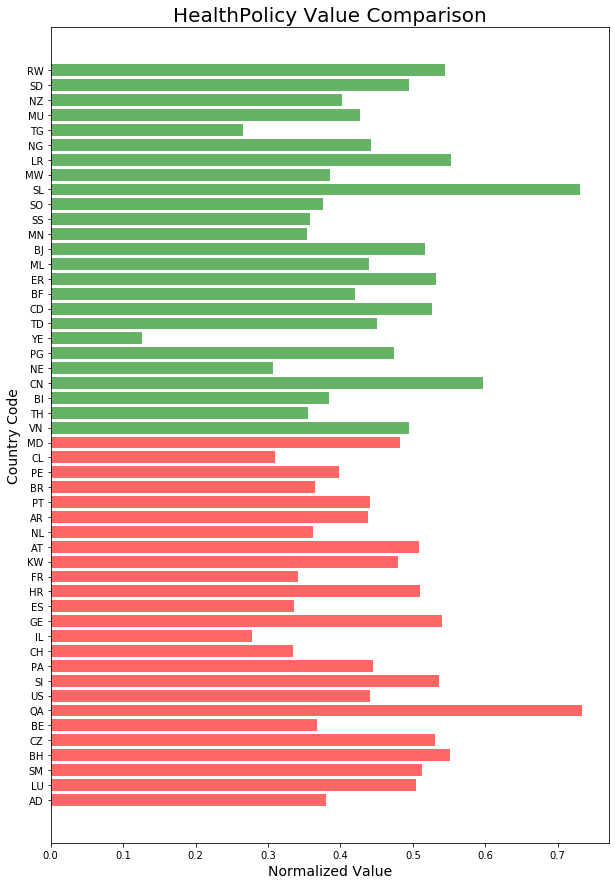

In [47]:
x = ["AD","LU","SM","BH","CZ","BE","QA","US","SI","PA","CH","IL","GE","ES","HR","FR", "KW","AT","NL","AR","PT","BR","PE","CL","MD","VN","TH","BI","CN","NE","PG","YE","TD","CD","BF","ER","ML","BJ","MN","SS","SO","SL","MW","LR","NG","TG","MU", "NZ","SD","RW"]
y2 = [AD_health_average,LU_health_average,SM_health_average,BH_health_average,CZ_health_average,BE_health_average, QA_health_average,US_health_average,SI_health_average,PA_health_average,CH_health_average,IL_health_average, GE_health_average,ES_health_average,HR_health_average,FR_health_average,KW_health_average,AT_health_average, NL_health_average,AR_health_average,PT_health_average,BR_health_average,PE_health_average,CL_health_average, MD_health_average,VN_health_average,TH_health_average,BI_health_average,CN_health_average,NE_health_average, PG_health_average,YE_health_average,TD_health_average,CD_health_average,BF_health_average,ER_health_average, ML_health_average,BJ_health_average,MN_health_average,SS_health_average,SO_health_average,SL_health_average, MW_health_average,LR_health_average,NG_health_average,TG_health_average,MU_health_average,NZ_health_average,SD_health_average,RW_health_average]

plt.figure(figsize=(10,15))

plt.title('HealthPolicy Value Comparison',fontsize=20)
plt.xlabel(u'Normalized Value',fontsize=14)
plt.ylabel(u'Country Code',fontsize=14)
plt.barh(x, y2, alpha=0.6, color='rrrrrrrrrrrrrrrrrrrrrrrrrggggggggggggggggggggggggg')
plt.show()

## My conclusion: There is no obvious correlation between a single policy (e.g. closure policy) and performance towards COVID-19 which means you can't stop the spread of COVID-19 by just obeying the health policy but reopening the workplace unlimitedly. We should try to follow every good policy as much as possible. Those policies' influence are combined.

# Part3: 
# Sub-HealthPolicy Index Differences between Different Countries

## Load data

In [ ]:
xls = pd.ExcelFile("https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/timeseries/OxCGRT_timeseries_all.xlsx")

In [3]:
# Load CSV data directly from the URL with pandas, the options are needed to prevent
# reading of records with key "NA" (Namibia) as NaN
data = pd.read_csv(
    "https://storage.googleapis.com/covid19-open-data/v2/oxford-government-response.csv",
    keep_default_na=False,
    na_values=[""],
)

# NOTE: We are only downloading the last day of data, but you can download all
# the data at once if you'd like by changing the URL to:
# https://storage.googleapis.com/covid19-open-data/v2/main.csv

# Print a small snippet of the dataset
print(f"The dataset currently contains {len(data)} records, here is a sample:")

The dataset currently contains 88783 records, here is a sample:


In [5]:
data_health_testing_policy = data[['date','key', 'testing_policy']] 
s1 = (data_health_testing_policy['testing_policy'] - data_health_testing_policy['testing_policy'].min())/(data_health_testing_policy['testing_policy'].max() - data_health_testing_policy['testing_policy'].min())
data_health_testing_policy = data_health_testing_policy.drop(['testing_policy'],axis=1)
data_health_testing_policy.insert(2,'testing_policy',s1)
data_health_testing_policy

,date,key,testing_policy
0,2020-01-01,AD,0.000000
1,2020-01-01,AE,0.000000
2,2020-01-01,AF,0.000000
3,2020-01-01,AL,0.000000
4,2020-01-01,AO,0.000000
...,...,...,...
86977,2020-12-05,NG,0.333333
86978,2020-12-05,NI,0.333333
86979,2020-12-05,US_PA,NaN
86980,2020-12-05,US_WI,NaN


In [4]:
data_health_contact_tracing = data[['date','key', 'contact_tracing']] 
s1 = (data_health_contact_tracing['contact_tracing'] - data_health_contact_tracing['contact_tracing'].min())/(data_health_contact_tracing['contact_tracing'].max() - data_health_contact_tracing['contact_tracing'].min())
data_health_contact_tracing = data_health_contact_tracing.drop(['contact_tracing'],axis=1)
data_health_contact_tracing.insert(2,'contact_tracing',s1)

In [5]:
data_health_emergency_investment_in_healthcare = data[['date','key', 'emergency_investment_in_healthcare']] 
s1 = (data_health_emergency_investment_in_healthcare['emergency_investment_in_healthcare'] - data_health_emergency_investment_in_healthcare['emergency_investment_in_healthcare'].min())/(data_health_emergency_investment_in_healthcare['emergency_investment_in_healthcare'].max() - data_health_emergency_investment_in_healthcare['emergency_investment_in_healthcare'].min())
data_health_emergency_investment_in_healthcare = data_health_emergency_investment_in_healthcare.drop(['emergency_investment_in_healthcare'],axis=1)
data_health_emergency_investment_in_healthcare.insert(2,'emergency_investment_in_healthcare',s1)

In [6]:
data_health_investment_in_vaccines = data[['date','key', 'investment_in_vaccines']] 
s1 = (data_health_investment_in_vaccines['investment_in_vaccines'] - data_health_investment_in_vaccines['investment_in_vaccines'].min())/(data_health_investment_in_vaccines['investment_in_vaccines'].max() - data_health_investment_in_vaccines['investment_in_vaccines'].min())
data_health_investment_in_vaccines = data_health_investment_in_vaccines.drop(['investment_in_vaccines'],axis=1)
data_health_investment_in_vaccines.insert(2,'investment_in_vaccines',s1)

## Preprocess Data

In [9]:
data_health_testing_policy_AU = data_health_testing_policy[data_health_testing_policy['key'] == "AU"]
AU_testing_policy_average = data_health_testing_policy_AU.mean(axis=0)
AU_testing_policy_average = AU_testing_policy_average.mean()
print(AU_testing_policy_average)
data_health_contact_tracing_AU = data_health_contact_tracing[data_health_contact_tracing['key'] == "AU"]
AU_contact_tracing_average = data_health_contact_tracing_AU.mean(axis=0)
AU_contact_tracing_average = AU_contact_tracing_average.mean()
print(AU_contact_tracing_average)
data_health_emergency_investment_in_healthcare_AU = data_health_emergency_investment_in_healthcare[data_health_emergency_investment_in_healthcare['key'] == "AU"]
AU_emergency_investment_in_healthcare_average = data_health_emergency_investment_in_healthcare_AU.mean(axis=0)
AU_emergency_investment_in_healthcare_average = AU_emergency_investment_in_healthcare_average.mean()
print(AU_emergency_investment_in_healthcare_average)
data_health_investment_in_vaccines_AU = data_health_investment_in_vaccines[data_health_investment_in_vaccines['key'] == "AU"]
AU_investment_in_vaccines_average = data_health_investment_in_vaccines_AU.mean(axis=0)
AU_investment_in_vaccines_average = AU_investment_in_vaccines_average.mean()
print(AU_investment_in_vaccines_average)
data_facial_coverings = pd.read_excel(xls, 'h6_facial_coverings')
data_facial_coverings_AU = data_facial_coverings[data_facial_coverings['country_name'] == "Australia"]
data_facial_coverings_AU = data_facial_coverings_AU.drop(['country_code','country_name'],axis=1)
data_facial_coverings_AU_average = data_facial_coverings_AU.mean(axis=1)
data_facial_coverings_AU_average = data_facial_coverings_AU_average/(data_facial_coverings_AU.max(axis=1)-data_facial_coverings_AU.min(axis=1))
data_facial_coverings_AU_average = data_facial_coverings_AU_average.mean()
print(data_facial_coverings_AU_average)

0.7174129353233832
0.9283582089552239
2.2910983079651246e-05
0.0010561259347230281


## Compare the results between different countries(countries classification is from this website: https://www.endcoronavirus.org/countries)

## Green means best performance, yellow means moderate performance and red means worst performance.

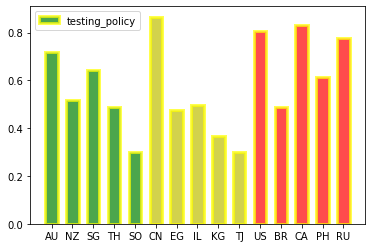

In [29]:
x = ["AU","NZ","SG","TH","SO","CN","EG","IL","KG","TJ","US","BR","CA","PH","RU"]
y = [AU_testing_policy_average ,NZ_testing_policy_average ,SG_testing_policy_average ,TH_testing_policy_average ,SO_testing_policy_average ,
     CN_testing_policy_average ,EG_testing_policy_average ,IL_testing_policy_average ,KG_testing_policy_average ,TJ_testing_policy_average ,
     US_testing_policy_average ,BR_testing_policy_average ,CA_testing_policy_average ,PH_testing_policy_average ,RU_testing_policy_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='gggggyyyyyrrrrr', edgecolor='yellow', label='testing_policy', lw=3)
plt.legend(loc='upper left')
plt.show()

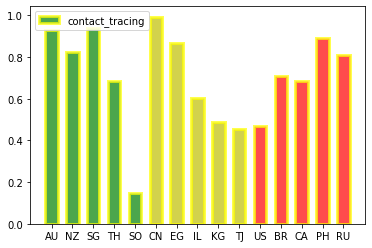

In [30]:
x = ["AU","NZ","SG","TH","SO","CN","EG","IL","KG","TJ","US","BR","CA","PH","RU"]
y = [AU_contact_tracing_average ,NZ_contact_tracing_average ,SG_contact_tracing_average ,TH_contact_tracing_average ,SO_contact_tracing_average ,
     CN_contact_tracing_average ,EG_contact_tracing_average ,IL_contact_tracing_average ,KG_contact_tracing_average ,TJ_contact_tracing_average ,
     US_contact_tracing_average ,BR_contact_tracing_average ,CA_contact_tracing_average ,PH_contact_tracing_average ,RU_contact_tracing_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='gggggyyyyyrrrrr', edgecolor='yellow', label='contact_tracing', lw=3)
plt.legend(loc='upper left')
plt.show()

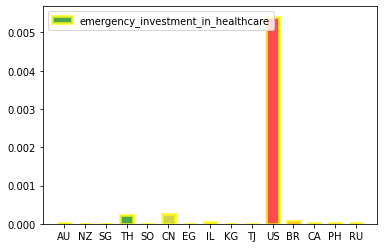

In [31]:
x = ["AU","NZ","SG","TH","SO","CN","EG","IL","KG","TJ","US","BR","CA","PH","RU"]
y = [AU_emergency_investment_in_healthcare_average ,NZ_emergency_investment_in_healthcare_average ,SG_emergency_investment_in_healthcare_average ,TH_emergency_investment_in_healthcare_average ,SO_emergency_investment_in_healthcare_average ,
     CN_emergency_investment_in_healthcare_average ,EG_emergency_investment_in_healthcare_average ,IL_emergency_investment_in_healthcare_average ,KG_emergency_investment_in_healthcare_average ,TJ_emergency_investment_in_healthcare_average ,
     US_emergency_investment_in_healthcare_average ,BR_emergency_investment_in_healthcare_average ,CA_emergency_investment_in_healthcare_average ,PH_emergency_investment_in_healthcare_average ,RU_emergency_investment_in_healthcare_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='gggggyyyyyrrrrr', edgecolor='yellow', label='emergency_investment_in_healthcare', lw=3)
plt.legend(loc='upper left')
plt.show()

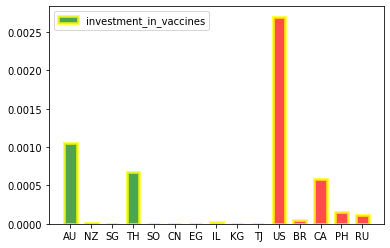

In [32]:
x = ["AU","NZ","SG","TH","SO","CN","EG","IL","KG","TJ","US","BR","CA","PH","RU"]
y = [AU_investment_in_vaccines_average ,NZ_investment_in_vaccines_average ,SG_investment_in_vaccines_average ,TH_investment_in_vaccines_average ,SO_investment_in_vaccines_average ,
     CN_investment_in_vaccines_average ,EG_investment_in_vaccines_average ,IL_investment_in_vaccines_average ,KG_investment_in_vaccines_average ,TJ_investment_in_vaccines_average ,
     US_investment_in_vaccines_average ,BR_investment_in_vaccines_average ,CA_investment_in_vaccines_average ,PH_investment_in_vaccines_average ,RU_investment_in_vaccines_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='gggggyyyyyrrrrr', edgecolor='yellow', label='investment_in_vaccines', lw=3)
plt.legend(loc='upper left')
plt.show()

## Compare the results between different countries(IL,GB,MX,CN,TJ,SG)

## From https://www.kaggle.com/tarunkr/covid-19-case-study-analysis-viz-comparisons, consider 1. Mortality Rate (per 100): Italy: 11.98, United Kingdom: 10.65, Mexico: 10.55, China: 5.24, Tajikistan: 0.78 Singapore: 0.05

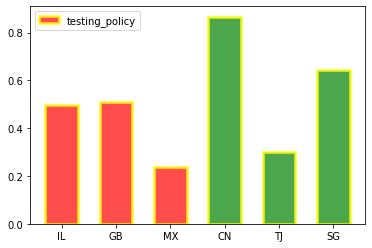

In [33]:
x = ["IL","GB","MX","CN","TJ","SG"]
y = [IL_testing_policy_average ,GB_testing_policy_average ,MX_testing_policy_average ,
     CN_testing_policy_average ,TJ_testing_policy_average ,SG_testing_policy_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='rrrggg', edgecolor='yellow', label='testing_policy', lw=3)
plt.legend(loc='upper left')
plt.show()

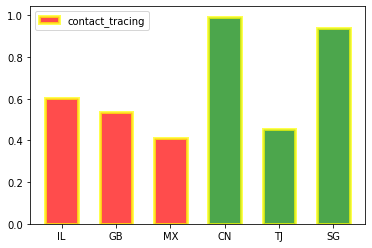

In [34]:
x = ["IL","GB","MX","CN","TJ","SG"]
y = [IL_contact_tracing_average ,GB_contact_tracing_average ,MX_contact_tracing_average ,
     CN_contact_tracing_average ,TJ_contact_tracing_average ,SG_contact_tracing_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='rrrggg', edgecolor='yellow', label='contact_tracing', lw=3)
plt.legend(loc='upper left')
plt.show()

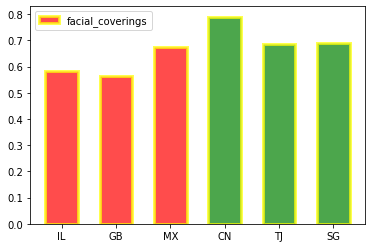

In [49]:
x = ["IL","GB","MX","CN","TJ","SG"]
y = [data_facial_coverings_IL_average ,data_facial_coverings_GB_average ,data_facial_coverings_MX_average ,
     data_facial_coverings_CN_average ,data_facial_coverings_TJ_average ,data_facial_coverings_SG_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='rrrggg', edgecolor='yellow', label='facial_coverings', lw=3)
plt.legend(loc='upper left')
plt.show()

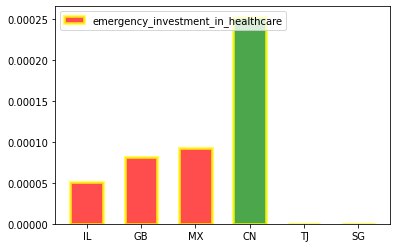

In [36]:
x = ["IL","GB","MX","CN","TJ","SG"]
y = [IL_emergency_investment_in_healthcare_average ,GB_emergency_investment_in_healthcare_average ,MX_emergency_investment_in_healthcare_average ,
     CN_emergency_investment_in_healthcare_average ,TJ_emergency_investment_in_healthcare_average ,SG_emergency_investment_in_healthcare_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='rrrggg', edgecolor='yellow', label='emergency_investment_in_healthcare', lw=3)
plt.legend(loc='upper left')
plt.show()


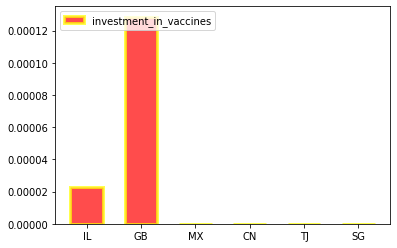

In [37]:
x = ["IL","GB","MX","CN","TJ","SG"]
y = [IL_investment_in_vaccines_average ,GB_investment_in_vaccines_average ,MX_investment_in_vaccines_average ,
     CN_investment_in_vaccines_average ,TJ_investment_in_vaccines_average ,SG_investment_in_vaccines_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='rrrggg', edgecolor='yellow', label='investment_in_vaccines', lw=3)
plt.legend(loc='upper left')
plt.show()


## Compare the results between different countries(BR,KG,CA,EG,KR,CN)

## From https://www.kaggle.com/tarunkr/covid-19-case-study-analysis-viz-comparisons, consider 2. Incident_Rate: Brazil: 2130.34, Kazakhstan: 571.25, Canada: 382.24, Egypt: 99.58, South Korea: 44.81, China: 6.43¶

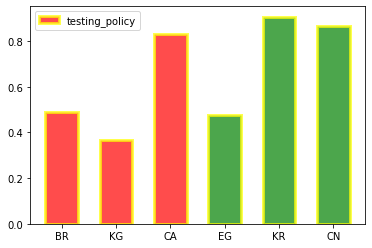

In [38]:
x = ["BR","KG","CA","EG","KR","CN"]
y = [BR_testing_policy_average ,KG_testing_policy_average ,CA_testing_policy_average ,
     EG_testing_policy_average ,KR_testing_policy_average ,CN_testing_policy_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='rrrggg', edgecolor='yellow', label='testing_policy', lw=3)
plt.legend(loc='upper left')
plt.show()

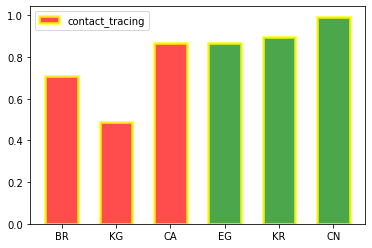

In [39]:
x = ["BR","KG","CA","EG","KR","CN"]
y = [BR_contact_tracing_average ,KG_contact_tracing_average ,EG_contact_tracing_average ,
     EG_contact_tracing_average ,KR_contact_tracing_average ,CN_contact_tracing_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='rrrggg', edgecolor='yellow', label='contact_tracing', lw=3)
plt.legend(loc='upper left')
plt.show()

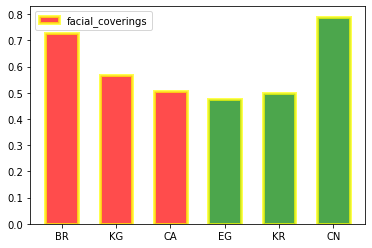

In [48]:
x = ["BR","KG","CA","EG","KR","CN"]
y = [data_facial_coverings_BR_average ,data_facial_coverings_KG_average ,data_facial_coverings_CA_average ,
     data_facial_coverings_EG_average ,data_facial_coverings_KR_average ,data_facial_coverings_CN_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='rrrggg', edgecolor='yellow', label='facial_coverings', lw=3)
plt.legend(loc='upper left')
plt.show()

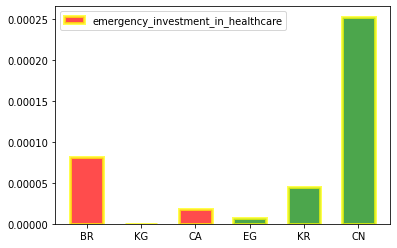

In [41]:
x = ["BR","KG","CA","EG","KR","CN"]
y = [BR_emergency_investment_in_healthcare_average ,KG_emergency_investment_in_healthcare_average ,CA_emergency_investment_in_healthcare_average ,
     EG_emergency_investment_in_healthcare_average ,KR_emergency_investment_in_healthcare_average ,CN_emergency_investment_in_healthcare_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='rrrggg', edgecolor='yellow', label='emergency_investment_in_healthcare', lw=3)
plt.legend(loc='upper left')
plt.show()

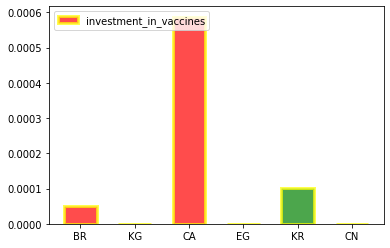

In [42]:
x = ["BR","KG","CA","EG","KR","CN"]
y = [BR_investment_in_vaccines_average ,KG_investment_in_vaccines_average ,CA_investment_in_vaccines_average ,
     EG_investment_in_vaccines_average ,KR_investment_in_vaccines_average ,CN_investment_in_vaccines_average]
plt.bar(x, y, alpha=0.7, width=0.6, color='rrrggg', edgecolor='yellow', label='investment_in_vaccines', lw=3)
plt.legend(loc='upper left')
plt.show()